In [14]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/job.11870695/ipykernel_108182/3391910190.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [16]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("Project/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:09<00:00, 28.46it/s]


In [17]:
# Convert the metadata columns 'input_size' and 'num_tasks' to performance data, forcing an overwrite
tk.metadata_column_to_perfdata("input_size", overwrite=True)
tk.metadata_column_to_perfdata("num_tasks", overwrite=True)
tk.metadata_column_to_perfdata("input_type", overwrite=True)


In [18]:
# Reset the index if 'input_size', 'num_tasks', or 'input_type' are part of it
if 'input_size' in tk.dataframe.index.names or 'num_tasks' in tk.dataframe.index.names or 'input_type' in tk.dataframe.index.names:
    tk.dataframe = tk.dataframe.reset_index()

# Convert the metadata columns 'input_size', 'num_tasks', and 'input_type' to performance data, forcing an overwrite
tk.metadata_column_to_perfdata("input_size", overwrite=True)
tk.metadata_column_to_perfdata("num_tasks", overwrite=True)
tk.metadata_column_to_perfdata("input_type", overwrite=True)

# Set the necessary index back for easier access (optional depending on your needs)
tk.dataframe = tk.dataframe.set_index(["input_size", "num_tasks", "input_type"]).sort_index()

# Confirm the changes by displaying the first few rows
print(tk.dataframe.head())


                                    nid   spot.channel  Min time/rank  \
input_size num_tasks input_type                                         
65536      2         1%_perturbed   1.0  regionprofile       0.348135   
                     1%_perturbed  18.0  regionprofile       0.000084   
                     1%_perturbed  15.0  regionprofile       0.000004   
                     1%_perturbed  17.0  regionprofile       0.000004   
                     1%_perturbed   2.0  regionprofile       0.000031   

                                   Max time/rank  Avg time/rank  Total time  \
input_size num_tasks input_type                                               
65536      2         1%_perturbed       0.348136       0.348136    0.696271   
                     1%_perturbed       0.002408       0.001246    0.002492   
                     1%_perturbed       0.000004       0.000004    0.000008   
                     1%_perturbed       0.000005       0.000005    0.000009   
              

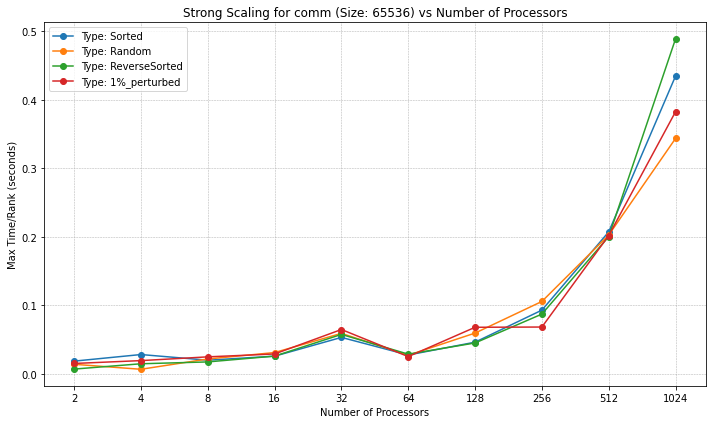

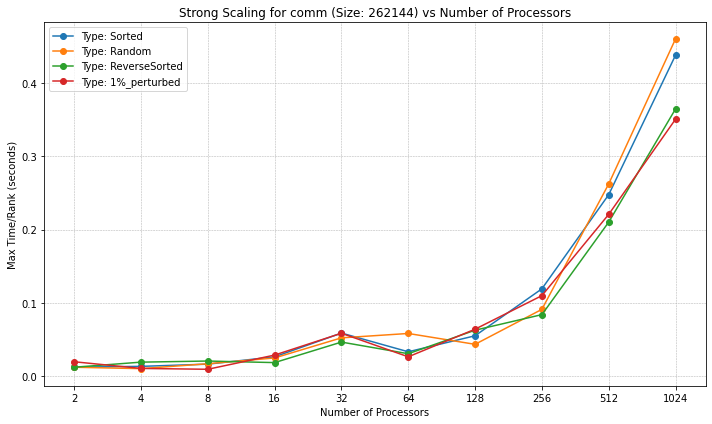

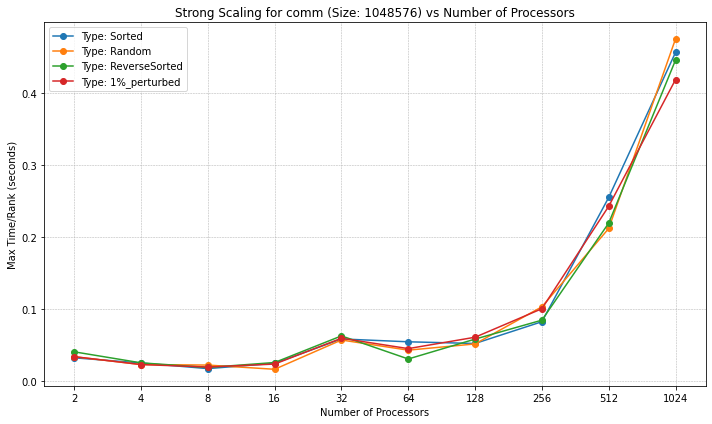

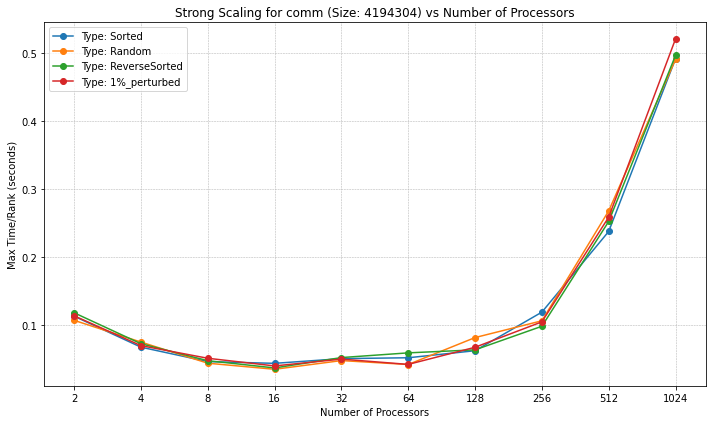

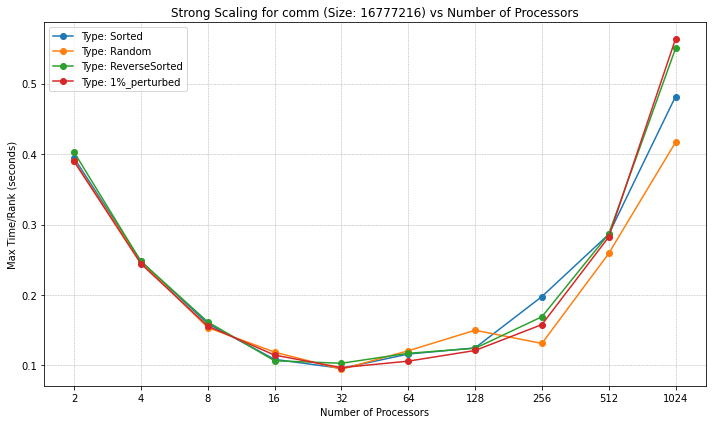

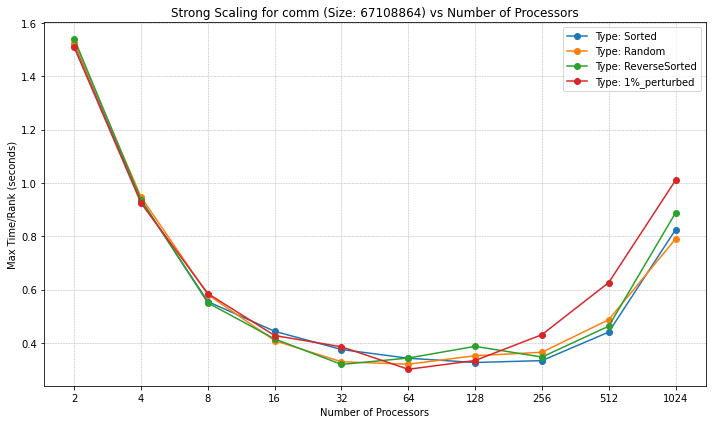

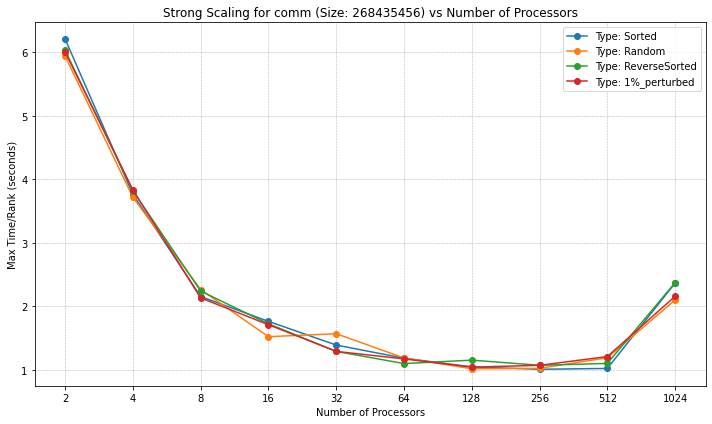

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the strong scaling plot function
def plot_strong_scaling(df, phase, input_sizes, input_types):
    # Define x-axis tick positions (base-2 progression)
    x_ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    for input_size in input_sizes:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input type to plot the data for the current input_size
        for input_type in input_types:
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_size') == input_size) &
                        (df.index.get_level_values('input_type') == input_type) &
                        (df['name'] == phase)]
            
            # Plot the Max time/rank for each num_tasks (or processors)
            plt.plot(subset.index.get_level_values('num_tasks'), subset['Max time/rank'], 
                     label=f"Type: {input_type}", marker='o')
        
        # Set x-axis to a logarithmic scale for even spacing
        plt.xscale('log', base=2)
        
        # Set x-axis tick positions and format them to show actual values
        plt.xticks(x_ticks)  # Set the positions
        plt.gca().get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
        
        # Labels, title, and grid
        plt.xlabel('Number of Processors')
        plt.ylabel('Max Time/Rank (seconds)')
        plt.title(f"Strong Scaling for {phase} (Size: {input_size}) vs Number of Processors")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

input_sizes = tk.dataframe.index.get_level_values('input_size').unique()  # Get unique input sizes from the index
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']

# Call the function for comp_large phase, which will generate 7 graphs, one per input size
plot_strong_scaling(tk.dataframe, 'comm', input_sizes, input_types) # Switch between phases 



plot_strong_scaling(tk.dataframe, 'comm', input_sizes, input_types)

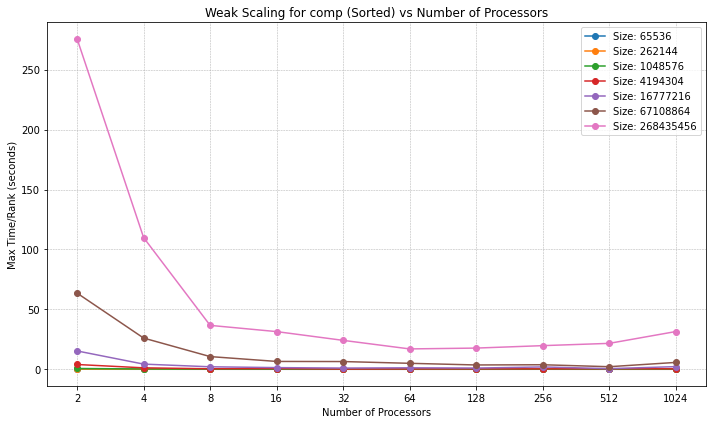

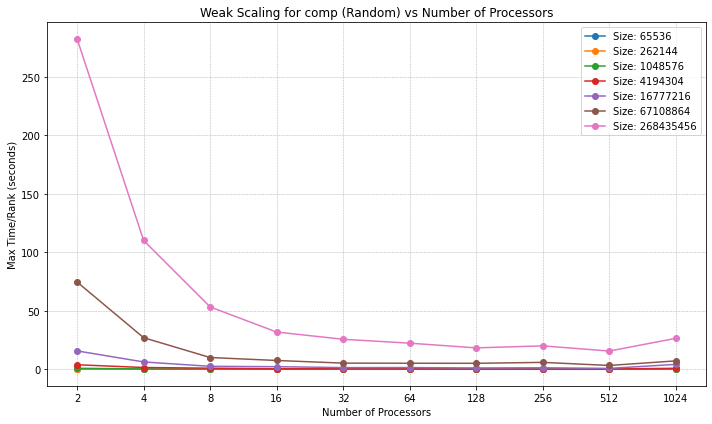

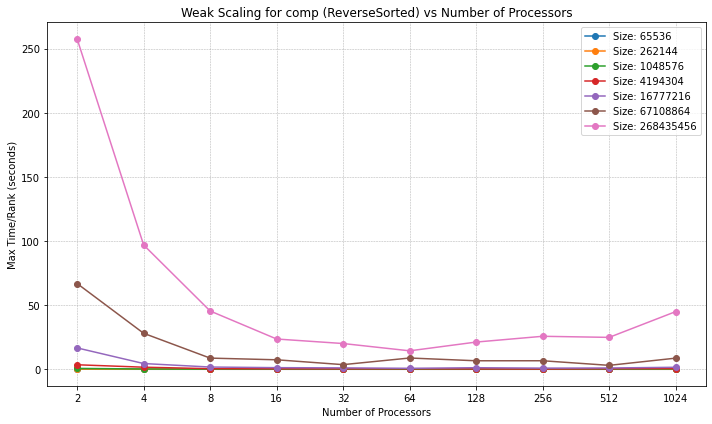

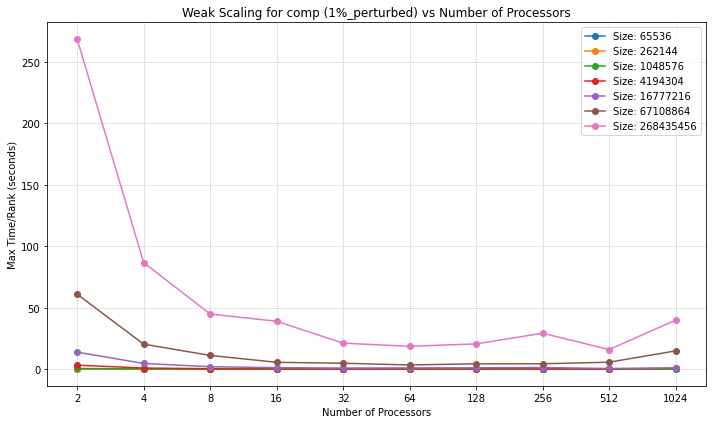

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the weak scaling plot function
def plot_weak_scaling(df, phase, input_types, input_sizes):
    # Define x-axis tick positions (powers of 2)
    x_ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size to plot the data for the current input type
        for input_size in input_sizes:
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_size') == input_size) &
                        (df.index.get_level_values('input_type') == input_type) &
                        (df['name'] == phase)]
            
            # Plot the Max time/rank for each num_tasks (or processors)
            plt.plot(subset.index.get_level_values('num_tasks'), subset['Max time/rank'], 
                     label=f"Size: {input_size}", marker='o')
        
        # Set x-axis to logarithmic scale for even spacing
        plt.xscale('log', base=2)
        
        # Set x-axis tick positions and format them to show actual values
        plt.xticks(x_ticks)
        plt.gca().get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
        
        # Labels, title, and grid
        plt.xlabel('Number of Processors')
        plt.ylabel('Max Time/Rank (seconds)')
        plt.title(f"Weak Scaling for {phase} ({input_type}) vs Number of Processors")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Consistent grid style
        plt.tight_layout()
        plt.show()

input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']
input_sizes = tk.dataframe.index.get_level_values('input_size').unique()  

# Call the function for the specified phase
plot_weak_scaling(tk.dataframe, 'comp', input_types, input_sizes) # Switch between phases


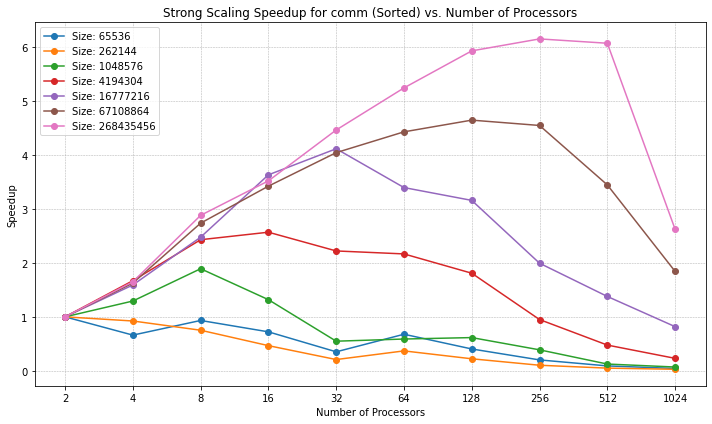

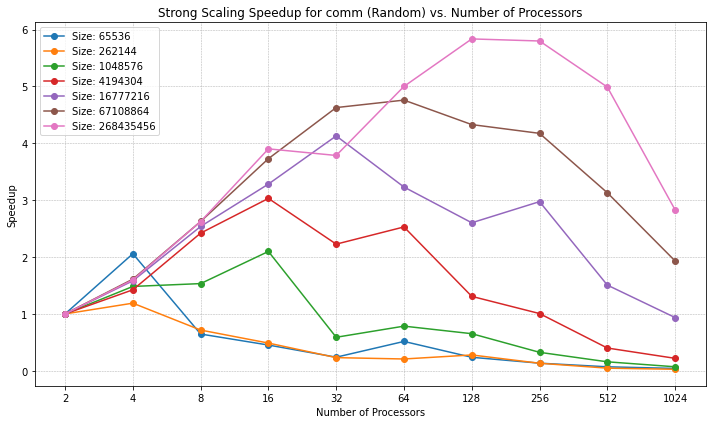

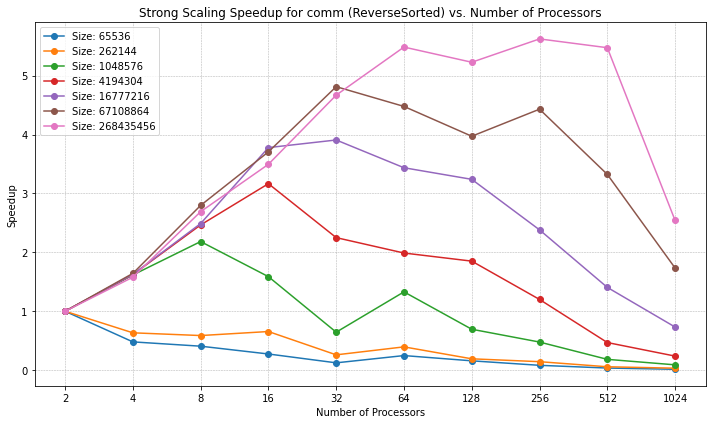

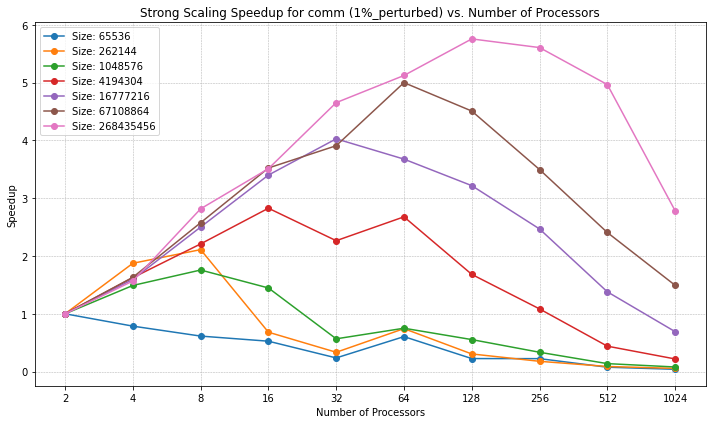

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the strong scaling speedup plot function
def plot_strong_scaling_speedup(df, phase, input_types):
    # Define x-axis tick positions (powers of 2 for even spacing)
    x_ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    # Loop through each input type to create a separate graph
    for input_type in input_types:
        plt.figure(figsize=(10, 6))
        
        # Loop through each input size and calculate speedup
        for input_size in df.index.get_level_values('input_size').unique():
            # Filter the dataframe based on input_size, input_type, and phase
            subset = df[(df.index.get_level_values('input_type') == input_type) &
                        (df.index.get_level_values('input_size') == input_size) &
                        (df['name'] == phase)]
            
            # Calculate the speedup based on the Max time for 2 processors (num_tasks == 2)
            base_time = subset[subset.index.get_level_values('num_tasks') == 2]['Max time/rank'].values[0]
            speedup = base_time / subset['Max time/rank']
            
            # Plot the speedup for each input_size
            plt.plot(subset.index.get_level_values('num_tasks'), speedup, 
                     label=f"Size: {input_size}", marker='o')
        
        # Set x-axis to a logarithmic scale for even spacing
        plt.xscale('log', base=2)
        
        # Set x-axis tick positions and format them to show actual values
        plt.xticks(x_ticks)
        plt.gca().get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
        
        # Labels, title, and grid
        plt.xlabel('Number of Processors')
        plt.ylabel('Speedup')
        plt.title(f"Strong Scaling Speedup for {phase} ({input_type}) vs. Number of Processors")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Consistent grid style
        plt.tight_layout()
        plt.show()

# Define input types
input_types = ['Sorted', 'Random', 'ReverseSorted', '1%_perturbed']

plot_strong_scaling_speedup(tk.dataframe, 'comm', input_types) # Switch between phases 
